In [81]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.autograd.functional import hessian
import matplotlib.pyplot as plt

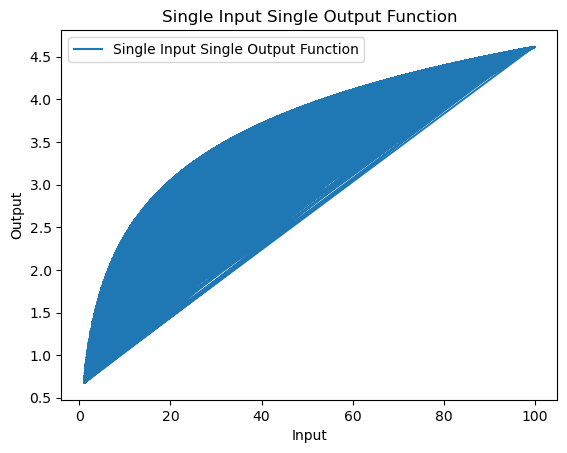

In [75]:
def target_function(x):
    return np.sinc(5*x) + np.log(x + 1)


np.random.seed(0)
x_train = np.random.uniform(1, 100, 10000).reshape(-1, 1)
y_train = target_function(x_train).reshape(-1, 1)

x_val = np.linspace(1, 100, 2000).reshape(-1, 1)
y_val = target_function(x_val).reshape(-1, 1)

# Plot the results
plt.plot(x_train, y_train, label='Single Input Single Output Function')
plt.title('Single Input Single Output Function')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.show()

In [76]:
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()
x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).float()

In [77]:
class DNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, no_of_layers):
        super(DNNModel, self).__init__()
        self.hidden_layers = nn.ModuleList([
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        ] + [nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        ) for _ in range(no_of_layers)])
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
        output = self.output_layer(x)
        return output

In [124]:
import torch
import torch.nn as nn
import numpy as np

def train_model(model, optimizer, x, y, epochs=3000):
    loss_func = nn.MSELoss()
    loss_arr = []
    epoch_arr = []
    grad_arr = []
    converged = False
    min_grad = 0.00001  # Defining a threshold for which we consider 'almost zero'

    for epoch in range(epochs):
        y_prediction = model(x)
        loss = loss_func(y_prediction, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_arr.append(epoch)
        loss_arr.append(loss.item())

        grad_all = sum(p.grad.data.norm(2).item()**2 for p in model.parameters() if p.grad is not None)
        grad_norm = grad_all ** 0.5
        grad_arr.append(grad_norm)

        if grad_norm < min_grad:
            converged = True
            print(f"Converged at epoch {epoch}")
            break

    minimal_ratio,lossm = compute_minimal_ratio(model, loss_func, x_train, y_train)

    return lossm, minimal_ratio


def compute_minimal_ratio(model, loss_func, data, target):
    model.eval()
    
    output = model(data)
    loss = loss_func(output, target)
    
    positive_curvatures = []
    total_curvatures = 0

    for param in model.parameters():
        if param.requires_grad and param.grad is not None:
            grad = torch.autograd.grad(loss, param, create_graph=True, retain_graph=True)[0]
            
            for i in range(grad.numel()):
                grad_elem = grad.view(-1)[i]
                
                second_derivative = torch.autograd.grad(grad_elem, param, retain_graph=True)[0].view(-1)[i]
                
                # Check if the curvature (second derivative) is positive
                if second_derivative > 0:
                    positive_curvatures.append(second_derivative)
                
                total_curvatures += 1

    minimal_ratio = len(positive_curvatures) / total_curvatures if total_curvatures > 0 else 0
    
    return minimal_ratio, loss.data.detach().numpy()

In [125]:
model = DNNModel(1, 20, 1, 2)  
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [126]:
loss_arr = []
min_ratio_arr = []
for index in range(100):
    loss_func = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)

    loss_value, min_ratio = train_model(model,optimizer, x_train, y_train)
    loss_arr.append(loss_value)
    min_ratio_arr.append(min_ratio)
    print("Trained "+str(index)+" time")

Trained 0 time
Trained 1 time
Trained 2 time
Trained 3 time
Trained 4 time
Trained 5 time
Trained 6 time
Trained 7 time
Trained 8 time
Trained 9 time
Trained 10 time
Trained 11 time
Trained 12 time
Trained 13 time
Trained 14 time
Trained 15 time
Trained 16 time
Trained 17 time
Trained 18 time
Trained 19 time
Trained 20 time
Trained 21 time
Trained 22 time
Trained 23 time
Trained 24 time
Trained 25 time
Trained 26 time
Trained 27 time
Trained 28 time
Trained 29 time
Trained 30 time
Trained 31 time
Trained 32 time
Trained 33 time
Trained 34 time
Trained 35 time
Trained 36 time
Trained 37 time
Trained 38 time
Trained 39 time
Trained 40 time
Trained 41 time
Trained 42 time
Trained 43 time
Trained 44 time
Trained 45 time
Trained 46 time
Trained 47 time
Trained 48 time
Trained 49 time
Trained 50 time
Trained 51 time
Trained 52 time
Trained 53 time
Trained 54 time
Trained 55 time
Trained 56 time
Trained 57 time
Trained 58 time
Trained 59 time
Trained 60 time
Trained 61 time
Trained 62 time
Tr

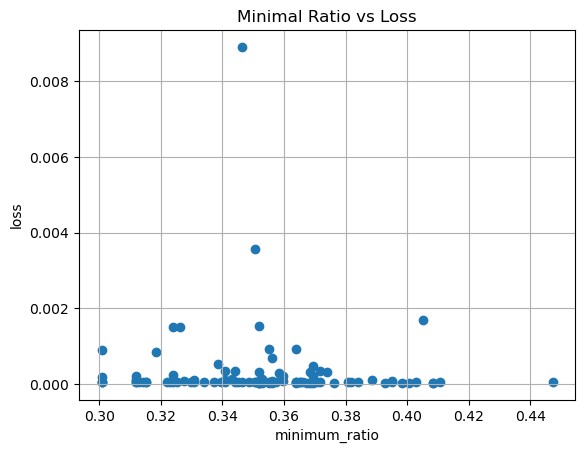

In [129]:
plt.figure()
plt.scatter(min_ratio_arr, loss_arr, marker='o')
plt.xlabel('minimum_ratio')
plt.ylabel('loss')
plt.title('Minimal Ratio vs Loss')
plt.grid(True)
plt.show()